In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date in chronological order (oldest to newest)
df = df.sort_index()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows (oldest dates):")
print(df.head())
print("\nLast few rows (newest dates):")
print(df.tail())

# Verify chronological order
print(f"\n✅ Data is sorted chronologically: {df.index.is_monotonic_increasing}")
print(f"Total trading days: {len(df)}")

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows (oldest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2020-01-02  3,244.67  3,258.14  3,235.53  3,257.85  1_01012020 to 12312020.csv
2020-01-03  3,226.36  3,246.15  3,222.34  3,234.85  1_01012020 to 12312020.csv
2020-01-06  3,217.55  3,246.84  3,214.64  3,246.28  1_01012020 to 12312020.csv
2020-01-07  3,241.86  3,244.91  3,232.43  3,237.18  1_01012020 to 12312020.csv
2020-01-08  3,238.59  3,267.07  3,236.67  3,253.05  1_01012020 to 12312020.csv

Last few rows (newest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2025-07-21  6,304.74  6,336.08  6,303.79  6,305.60  6_01012025 to 25072025.csv

In [3]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-01-02  3244.67  3258.14  3235.53  3257.85
2020-01-03  3226.36  3246.15  3222.34  3234.85
2020-01-06  3217.55  3246.84  3214.64  3246.28
2020-01-07  3241.86  3244.91  3232.43  3237.18
2020-01-08  3238.59  3267.07  3236.67  3253.05


In [4]:
# 2.1. Date Analysis and Verification
print("📅 DATE ANALYSIS")
print("="*50)

# Check for any gaps in the data
date_differences = df.index.to_series().diff()
business_days_gaps = date_differences[date_differences > pd.Timedelta(days=3)]

if len(business_days_gaps) > 0:
    print(f"⚠️ Found {len(business_days_gaps)} potential gaps in data (>3 days):")
    for date, gap in business_days_gaps.items():
        print(f"   Gap at {date}: {gap.days} days")
else:
    print("✅ No significant gaps found in the data")

# Show data distribution by year
print(f"\n📊 Data distribution by year:")
yearly_counts = df.groupby(df.index.year).size()
for year, count in yearly_counts.items():
    print(f"   {year}: {count} trading days")

# Check for duplicates
duplicates = df.index.duplicated().sum()
if duplicates > 0:
    print(f"\n⚠️ Found {duplicates} duplicate dates")
    df = df[~df.index.duplicated(keep='first')]
    print("✅ Duplicates removed")
else:
    print("\n✅ No duplicate dates found")

print(f"\nFinal dataset: {len(df)} unique trading days from {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")

📅 DATE ANALYSIS
⚠️ Found 42 potential gaps in data (>3 days):
   Gap at 2020-01-21 00:00:00: 4 days
   Gap at 2020-02-18 00:00:00: 4 days
   Gap at 2020-04-13 00:00:00: 4 days
   Gap at 2020-05-26 00:00:00: 4 days
   Gap at 2020-07-06 00:00:00: 4 days
   Gap at 2020-09-08 00:00:00: 4 days
   Gap at 2020-12-28 00:00:00: 4 days
   Gap at 2021-01-04 00:00:00: 4 days
   Gap at 2021-01-19 00:00:00: 4 days
   Gap at 2021-02-16 00:00:00: 4 days
   Gap at 2021-04-05 00:00:00: 4 days
   Gap at 2021-06-01 00:00:00: 4 days
   Gap at 2021-07-06 00:00:00: 4 days
   Gap at 2021-09-07 00:00:00: 4 days
   Gap at 2021-12-27 00:00:00: 4 days
   Gap at 2022-01-18 00:00:00: 4 days
   Gap at 2022-02-22 00:00:00: 4 days
   Gap at 2022-04-18 00:00:00: 4 days
   Gap at 2022-05-31 00:00:00: 4 days
   Gap at 2022-06-21 00:00:00: 4 days
   Gap at 2022-07-05 00:00:00: 4 days
   Gap at 2022-09-06 00:00:00: 4 days
   Gap at 2022-12-27 00:00:00: 4 days
   Gap at 2023-01-03 00:00:00: 4 days
   Gap at 2023-01-17 00:00

In [5]:
# 2. Feature Engineering
df["SMA_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["EMA_10"] = EMAIndicator(close=df["Close"], window=10).ema_indicator()
df["RSI"] = RSIIndicator(close=df["Close"], window=14).rsi()

In [6]:
# 3. Create target: 1 if next-day return is positive, else 0
df["Return"] = df["Close"].pct_change()
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

In [7]:
# 4. Drop NaNs
df.dropna(inplace=True)

In [8]:
# 6. Time-aware train/test split (last 100 days as test set)
print("🔄 TRAIN/TEST SPLIT")
print("="*50)

# Ensure data is sorted chronologically before split
df_sorted = df.sort_index()

# Define features and target from sorted data
features = ["SMA_10", "EMA_10", "RSI"]
X = df_sorted[features]
y = df_sorted["Target"]

# Time-aware split: last 100 days for testing
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

print(f"Training set:")
print(f"   • Size: {len(X_train)} samples")
print(f"   • Date range: {X_train.index.min().strftime('%Y-%m-%d')} to {X_train.index.max().strftime('%Y-%m-%d')}")
print(f"   • Target distribution: {y_train.value_counts().sort_index().to_dict()}")

print(f"\nTest set:")
print(f"   • Size: {len(X_test)} samples")
print(f"   • Date range: {X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')}")
print(f"   • Target distribution: {y_test.value_counts().sort_index().to_dict()}")

print(f"\n✅ Chronological order preserved in train/test split")

🔄 TRAIN/TEST SPLIT
Training set:
   • Size: 1285 samples
   • Date range: 2020-01-22 to 2025-03-03
   • Target distribution: {0: 596, 1: 689}

Test set:
   • Size: 100 samples
   • Date range: 2025-03-04 to 2025-07-25
   • Target distribution: {0: 40, 1: 60}

✅ Chronological order preserved in train/test split


In [9]:
# 6. Time-aware train/test split (last 100 days as test set)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]


In [10]:
# 7. Define and train models with proper preprocessing
from sklearn.preprocessing import StandardScaler

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays to avoid pandas compatibility issues
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == "Logistic Regression":
        # Use scaled data for Logistic Regression
        model.fit(X_train_scaled, y_train_np)
        y_pred = model.predict(X_test_scaled)
    else:
        # Use numpy arrays for other models
        model.fit(X_train_np, y_train_np)
        y_pred = model.predict(X_test_np)

    acc = accuracy_score(y_test_np, y_pred)
    report = classification_report(y_test_np, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test_np, y_pred)

    results[name] = {
        "model": model,
        "accuracy": acc,
        "report": report,
        "confusion_matrix": cm,
        "y_pred": y_pred
    }

print("✅ All models trained successfully!")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
✅ All models trained successfully!
Training XGBoost...
✅ All models trained successfully!


In [11]:
# 8. Compare model performance
print("="*60)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['report']['weighted avg']['precision'],
        'Recall': res['report']['weighted avg']['recall'],
        'F1-Score': res['report']['weighted avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nDetailed Performance Metrics:")
print(comparison_df.to_string(index=False))

# Find best model
best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
best_accuracy = comparison_df['Accuracy'].max()

print(f"\n🏆 Best Model: {best_model} (Accuracy: {best_accuracy:.4f})")

# Trading simulation comparison
print(f"\n💰 Trading Performance Comparison:")
for name, res in results.items():
    y_pred = res['y_pred']
    correct_predictions = (y_pred == y_test_np).sum()
    tp = ((y_pred == 1) & (y_test_np == 1)).sum()
    tn = ((y_pred == 0) & (y_test_np == 0)).sum()
    
    print(f"\n{name}:")
    print(f"   • Correct predictions: {correct_predictions}/{len(y_test_np)} ({res['accuracy']:.1%})")
    print(f"   • Successful UP predictions: {tp}")
    print(f"   • Successful DOWN predictions: {tn}")

📊 MODEL PERFORMANCE COMPARISON

Detailed Performance Metrics:
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression      0.50     0.5160    0.50    0.5049
      Random Forest      0.48     0.4883    0.48    0.4834
            XGBoost      0.49     0.4962    0.49    0.4927

🏆 Best Model: Logistic Regression (Accuracy: 0.5000)

💰 Trading Performance Comparison:

Logistic Regression:
   • Correct predictions: 50/100 (50.0%)
   • Successful UP predictions: 31
   • Successful DOWN predictions: 19

Random Forest:
   • Correct predictions: 48/100 (48.0%)
   • Successful UP predictions: 32
   • Successful DOWN predictions: 16

XGBoost:
   • Correct predictions: 49/100 (49.0%)
   • Successful UP predictions: 33
   • Successful DOWN predictions: 16


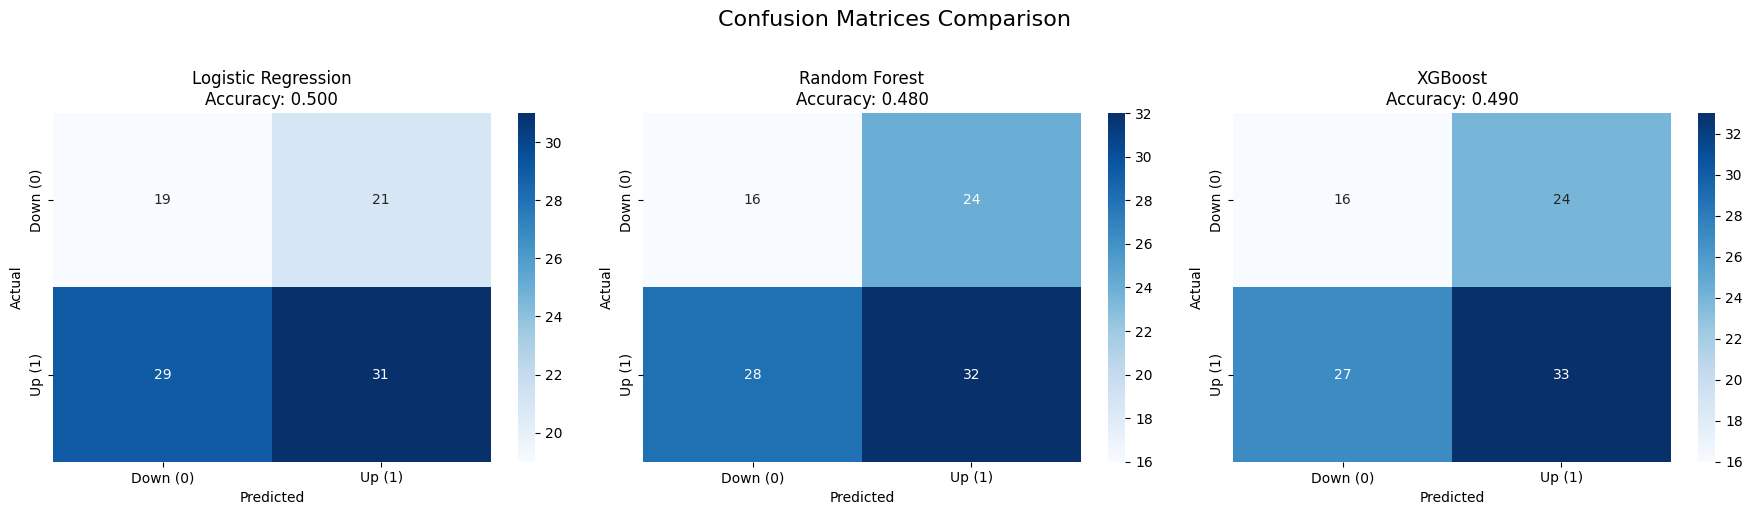

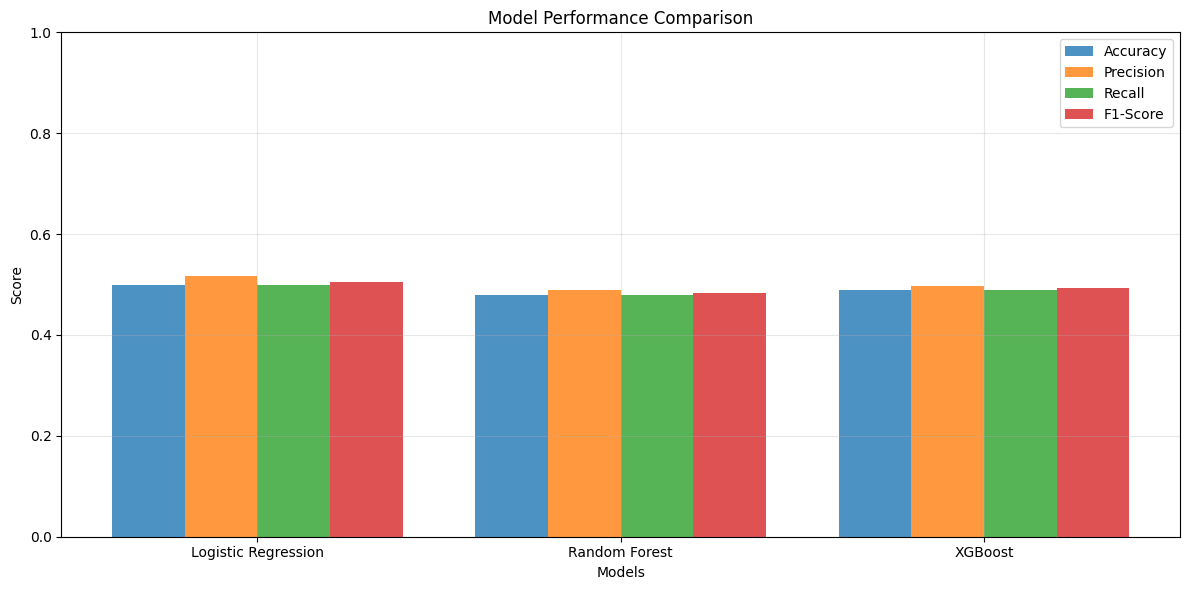

In [12]:
# 9. Visualize confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues", ax=axs[i],
                xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
    axs[i].set_title(f'{name}\nAccuracy: {res["accuracy"]:.3f}')
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

plt.suptitle('Confusion Matrices Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Performance bar chart
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, comparison_df[metric], width, label=metric, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, comparison_df['Model'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

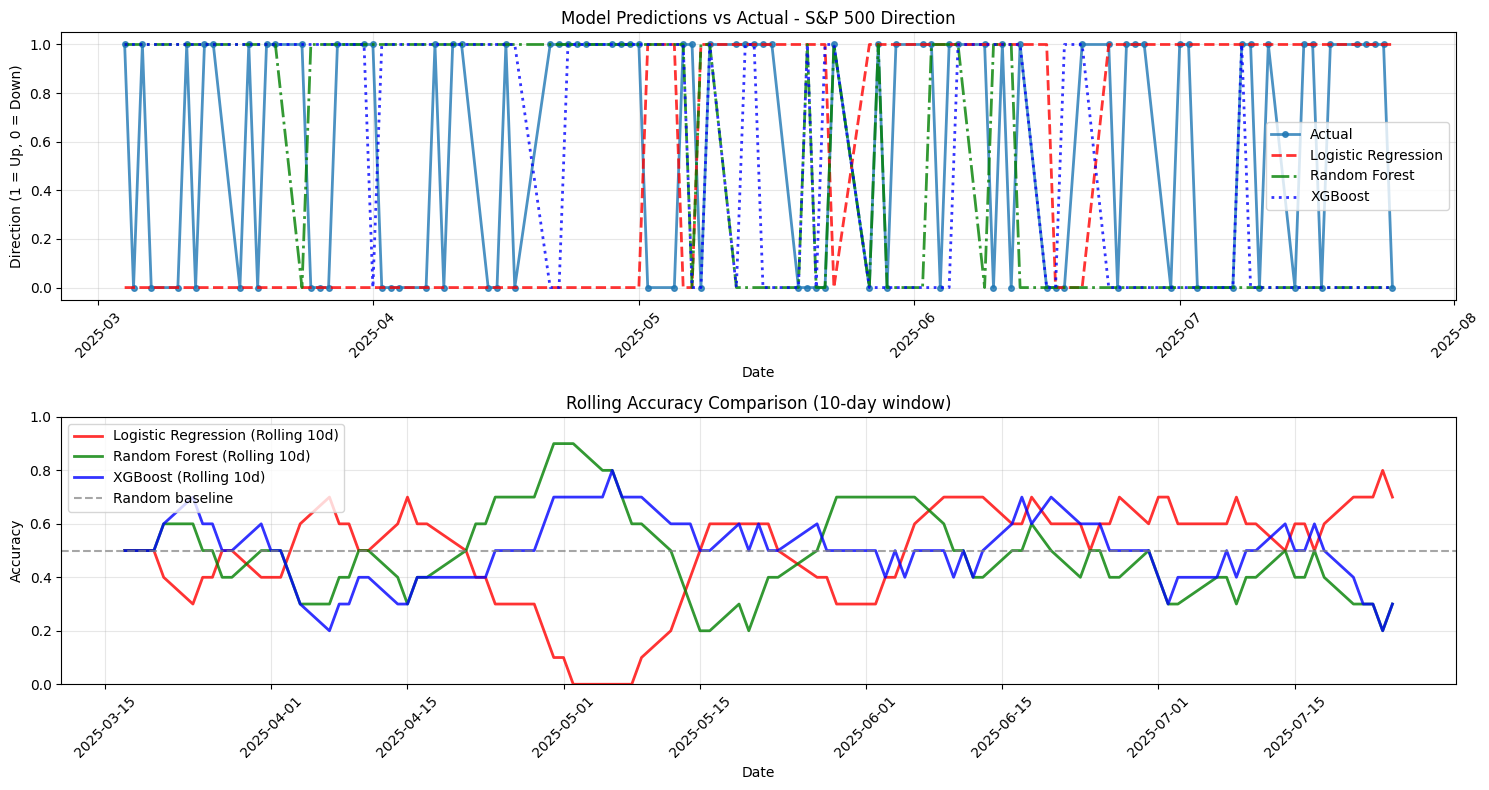


🏅 Model Ranking by Accuracy:
1. Logistic Regression: 0.5000
2. XGBoost: 0.4900
3. Random Forest: 0.4800


In [13]:
# 10. Plot prediction vs actual for all models
plt.figure(figsize=(15, 8))

# Main prediction plot
plt.subplot(2, 1, 1)
dates = y_test.index
plt.plot(dates, y_test.values, 'o-', label="Actual", linewidth=2, alpha=0.8, markersize=4)

colors = ['red', 'green', 'blue']
linestyles = ['--', '-.', ':']

for i, (name, res) in enumerate(results.items()):
    plt.plot(dates, res["y_pred"], label=name, linestyle=linestyles[i], 
             linewidth=2, alpha=0.8, color=colors[i])

plt.title("Model Predictions vs Actual - S&P 500 Direction")
plt.xlabel("Date")
plt.ylabel("Direction (1 = Up, 0 = Down)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Accuracy over time
plt.subplot(2, 1, 2)
window = 10  # 10-day rolling window

for i, (name, res) in enumerate(results.items()):
    correct_preds = (res["y_pred"] == y_test.values)
    rolling_accuracy = pd.Series(correct_preds).rolling(window=window).mean()
    plt.plot(dates, rolling_accuracy, label=f'{name} (Rolling {window}d)', 
             linewidth=2, alpha=0.8, color=colors[i])

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random baseline')
plt.title(f'Rolling Accuracy Comparison ({window}-day window)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Model ranking
print("\n🏅 Model Ranking by Accuracy:")
ranking = comparison_df.sort_values('Accuracy', ascending=False)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Accuracy']:.4f}")